<a href="https://colab.research.google.com/github/SovetovAleksey/ML_in_business/blob/4_quest/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from catboost import CatBoostClassifier

In [14]:
data = pd.read_csv('data.csv')
data = data.rename(columns = {"conversion": "target", "offer": "treatment"})
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [15]:
dummie_mapping = {
           'Buy One Get One': 1,
           'Discount': 1,
           'No Offer': 0}

data['treatment'] = data['treatment'].map(dummie_mapping)
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), data['target'], train_size=0.7, random_state=1)

treat_train = X_train['treatment']
treat_test = X_test['treatment']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

<ipython-input-19-d2efc626631b>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), data['target'], train_size=0.7, random_state=1)


((44800, 8), (19200, 8), (44800,), (19200,))

In [23]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['history']
cat_cols = ['zip_code', 'channel', 'recency']
base_cols = ['used_discount', 'used_bogo', 'is_referral', 'treatment']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [24]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

X_train = feature_processing.fit_transform(X_train)
X_test = feature_processing.fit_transform(X_test)

In [45]:
treatment_model = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
control_model = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)

score = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])

models = [SoloModel(treatment_model),
          ClassTransformation(treatment_model),
          TwoModels(estimator_trmnt=treatment_model, estimator_ctrl=control_model, method='vanilla')]

for model in models:
    md = model
    md.fit(X_train, y_train, treat_train)
    uplift = md.predict(X_test)
    
    score_10 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.1)
    score_20 = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.2)
    
    score = score.append({'model': type(md).__name__, 'uplift@10%': score_10, 'uplift@20%': score_20}, ignore_index=True)

In [46]:
score

,model,uplift@10%,uplift@20%
0,SoloModel,0.106057,0.076832
1,ClassTransformation,0.287656,0.213937
2,TwoModels,0.064979,0.071987


In [57]:
X_train

array([[1.10104e+03, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        1.00000e+00, 0.00000e+00],
       [8.94950e+02, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        1.00000e+00, 1.00000e+00],
       [2.99900e+01, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [7.88300e+01, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [3.15100e+01, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.53110e+02, 0.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00]])

In [62]:
X_train = pd.DataFrame(X_train)
features = [col for col in X_train]

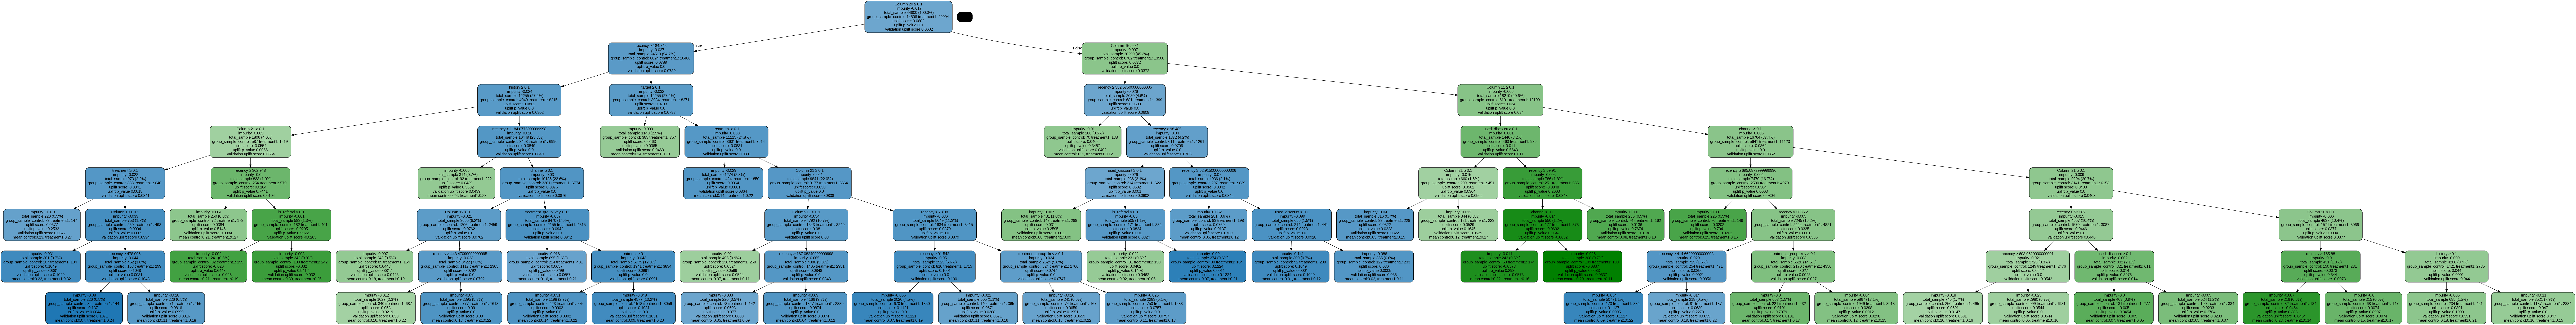

In [65]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())